# This notebook should be used as a guide for creating dataloaders in Pytorch
Official documentation: https://pytorch.org/docs/stable/data.html

## First, import basic functionalities that you may need

In [1]:
import numpy as np
import os
from glob import glob #glob is used to search for paths by using regex and variable text. e.g.: glob("./dataset/*.mid")
import pretty_midi
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

## Second, import the two functions that you'll need

In [2]:
#this are the basic functions in Pytorch for Dataset/Dataloader Creation
from torch.utils.data import Dataset, DataLoader
#in case we were dealing with CV
#from torchvision import transforms, utils

So, basically, and if I've understood correctly, we have two functions that we are going to use:
- Dataset: we'll use it to define our class (which will become a child of Dataset). It can be map-style or iterable-style. Normally we will use map-style, which means that the class must contain two protocols (mandatory)--> __getitem()__ and __len()__
- DataLoader: function that will call our batches of our Dataset. If our dataset is well defined and we don't need anything fancy (...) the default DataLoader should work just fine (Don't worry be happy)

In [3]:
def get_midi_files(source_path="../dataset/maestro-v1.0.0/**/*.midi",splits=(0.8,0.1,0.1),seed_int=666):
    if type(splits)!=tuple or sum(splits)!=1 or len(splits)!=3:
      raise Exception("splits should be a tuple of 3 doubles and the sum its element equal to 1")
    
    list_all_midi = glob(source_path)
    random.seed(seed_int)
    random.shuffle(list_all_midi)

    len_train=round(len(list_all_midi)*splits[0])
    len_val=round(len(list_all_midi)*splits[1])
    len_test=len(list_all_midi)-len_train-len_val
    
    return list_all_midi[:len_train],list_all_midi[len_train:len_val+len_train],list_all_midi[len_val+len_train:]

midi_files=get_midi_files()

In [4]:
def get_notes(midi_files=[""]):

    for idx_file,midi_file in enumerate(midi_files):

        #print("%d/%d adding file %s" % (idx_file+1,len(midi_files),os.path.basename(midi_file)))

        #Read the midi_file as a pretty midi object
        midi_score=pretty_midi.PrettyMIDI(midi_file)
        #simplified way, we only deal with the first instrument
        inst0=midi_score.instruments[0]
        score_song=np.zeros((5,len(inst0.notes)))
        end_time=midi_score.get_end_time()
        for i,note in enumerate(inst0.notes):
            if i!=0:
                score_song[:,i]=np.array([note.start,note.end,note.pitch/128,(note.start-score_song[0,i-1])/note.velocity,(note.end-note.start)/note.velocity])
            else:
                score_song[:,i]=np.array([note.start,note.end,note.pitch/128,0,(note.end-note.start)/note.velocity])

        if idx_file!=0:
            score=np.concatenate((score,score_song),axis=1)
        else:
            score=score_song
    #the result is a 2D np array of 3xN, where N represents the number of events in the song, 
    #and 3 are the components representing each event (pitch, distance to the previous and duration)
    score_relative=score[2:,:].transpose()
    
    score_relative[:,0]=(score_relative[:,0]-score_relative[:,0].mean())/(score_relative[:,0].std())   
    score_relative[:,1]=(score_relative[:,1]-score_relative[:,1].mean())/(score_relative[:,1].std())
    score_relative[:,2]=(score_relative[:,2]-score_relative[:,2].mean())/(score_relative[:,2].std())
    return score_relative   

In [10]:
score=get_notes(midi_files[0][0:1])

In [11]:
score[:,1].std()

1.0

In [5]:
#Let's define our dataset class
#we will allway have an _init__ function plus the two functions mentioned above. All of them will have self as an input. Also, __getitem__() will have idx as an input

class MusicData(Dataset):
    def __init__(self,seq_len=25,midi_files=[]):
        self.notes=self.get_notes(midi_files)
        self.seq_len=seq_len
    
    def __getitem__(self,idx):
        x = self.notes[idx:(idx+self.seq_len*2)].astype(np.float32)
        return (x[0:self.seq_len,:],x[self.seq_len:,:])
    
    def __len__(self):
        return self.notes.shape[0]-self.seq_len*2
        
    def get_notes(self,midi_files=[""]):

        for idx_file,midi_file in enumerate(midi_files):
            
            #print("%d/%d adding file %s" % (idx_file+1,len(midi_files),os.path.basename(midi_file)))
            
            #Read the midi_file as a pretty midi object
            midi_score=pretty_midi.PrettyMIDI(midi_file)
            #simplified way, we only deal with the first instrument
            inst0=midi_score.instruments[0]
            score_song=np.zeros((5,len(inst0.notes)))
            end_time=midi_score.get_end_time()
            for i,note in enumerate(inst0.notes):
                if i!=0:
                    score_song[:,i]=np.array([note.start,note.end,note.pitch/128,(note.start-score_song[0,i-1])/note.velocity,(note.end-note.start)/note.velocity])
                else:
                    score_song[:,i]=np.array([note.start,note.end,note.pitch/128,0,(note.end-note.start)/note.velocity])

            if idx_file!=0:
                score=np.concatenate((score,score_song),axis=1)
            else:
                score=score_song
        #the result is a 2D np array of 3xN, where N represents the number of events in the song, 
        #and 3 are the components representing each event (pitch, distance to the previous and duration)
        score_relative=score[2:,:].transpose()
        
        #normalize distance and lenght
            #score_relative[:,1]=(score_relative[:,1]-score_relative[:,1].min())/(score_relative[:,1].max()-score_relative[:,1].min())
            #score_relative[:,2]=(score_relative[:,2]-score_relative[:,2].min())/(score_relative[:,2].max()-score_relative[:,2].min())
        score_relative[:,0]=(score_relative[:,0]-score_relative[:,0].mean())/(score_relative[:,0].std())   
        score_relative[:,1]=(score_relative[:,1]-score_relative[:,1].mean())/(score_relative[:,1].std())
        score_relative[:,2]=(score_relative[:,2]-score_relative[:,2].mean())/(score_relative[:,2].std())
        
        return score_relative    


In [34]:
dataset_train = MusicData(seq_len=10, midi_files=midi_files[0][:10])
dataset_test = MusicData(seq_len=10, midi_files=midi_files[1][:10])
dataset_val = MusicData(seq_len=10, midi_files=midi_files[2][:10])

print("DONE LOADING DATA")

DONE LOADING DATA


In [35]:
BATCH_SIZE_TRAIN=50
BATCH_SIZE_VAL=15
BATCH_SIZE_TEST=50


training_generator = DataLoader(dataset_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
validating_generator = DataLoader(dataset_val, batch_size=BATCH_SIZE_VAL, shuffle=True)
testing_generator = DataLoader(dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [8]:
for i,batch in enumerate(training_generator):
    print(batch[0][0][0]) #---> the first element represents the size of the sequence (input, output). then we have [Batch_size,seq_len,tensor_size]--> [50,10,3]
    if (i+1)%10==0:
        break

tensor([ 0.1061, -0.0170,  0.3546])
tensor([ 0.6628, -0.0096, -0.1560])
tensor([-0.3115, -0.1506, -0.2219])
tensor([ 1.3588, -0.0592, -0.1913])
tensor([ 0.5932, -0.3834,  0.0338])
tensor([ 0.4540,  0.2004, -0.1608])
tensor([ 1.4979, -0.1457, -0.2371])
tensor([-0.1027,  0.1198, -0.1517])
tensor([ 0.8020, -0.4537,  0.1254])
tensor([ 1.2892, -0.1457, -0.0036])


## Creating an Model

Let's start by creating the fundamentals of a model in Pytorch. First, what torch libraries should you import?
- The essential should be ```import torch.nn as nn```. Your model will be a class inheriting from ```nn.Module```. This new class should always contain a ```__init__``` function and a ```forward``` function.
- To complement your model creation, another important library is ```import torch.nn.functional as F```. This will include some of the same functions that you could find in nn.
- If you plan to run the model in this same senction, then, you should also include ```import torch.optim as optim```

In [9]:
import torch #for example to use torch.zero
import torch.nn as nn
import torch.optim as optim

In [10]:
#lets define the our model as seq2seq LSTM
class GRUpred(nn.Module):
    def __init__(self,input_dim,rnn_dim=512,rnn_layers=2,bidirect=False):
        super(GRUpred, self).__init__()
        
        self.input_dim=input_dim
        self.rnn_dim=rnn_dim
        self.rnn_layers=rnn_layers
        self.bidirect=bidirect
        
        self.rnn=nn.GRU(input_size=input_dim,hidden_size=rnn_dim,num_layers=rnn_layers,batch_first=True,dropout=0.2,bidirectional=bidirect)
        
        self.regressor=nn.Sequential(nn.Linear(in_features=rnn_dim,out_features=rnn_dim),nn.Dropout(p=0.2),nn.Linear(in_features=rnn_dim,out_features=input_dim))
        
    def forward(self,input):
        
        batch_size=input.shape[0]
        
        h0=torch.zeros(self.rnn_layers*(1+int(self.bidirect)),batch_size,self.rnn_dim)
        
        output,hidden=self.rnn(input)
        
        output=self.regressor(hidden)
        
        return output

In [27]:
device=torch.device("cuda")
model=GRUpred(input_dim=3)
model_gpu=model.to(device)

criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
EPOCHS=100

loss_list=[]
loss_local=[]

for epoch in range(EPOCHS):
    
    for i,batch in enumerate(training_generator):
        
        x=batch[0].to(device)
        y=batch[1].to(device)
        
        y_hat=model_gpu.train()(x)
        
        loss=criterion(y_hat,y[:,-1])
        
        # Zero gradients, perform a backward pass, and update the weights.
        
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_local.append(loss.item())
        

    loss_list.append(np.asarray(loss_local).mean())
    print("Epoch {0}, loss {1}".format(epoch,np.asarray(loss_local).mean()))
    loss_local=[]
        

c:\users\marti\.virtualenvs\onlyuselydian-dlz89few\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([2, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, loss 0.9173637883821858
Epoch 1, loss 0.8733064964983444
Epoch 2, loss 0.8607943284553006
Epoch 3, loss 0.8580849156698789
Epoch 4, loss 0.8455308609256825
Epoch 5, loss 0.8275039218288446
Epoch 6, loss 0.8085174722249511
Epoch 7, loss 0.7853561477996798


In [152]:
a=model.eval()(batch[0].to(device))

In [154]:
a[:,0].max()

tensor(0.1537, device='cuda:0', grad_fn=<MaxBackward1>)

In [140]:
b=batch[1][0]

In [141]:
b


tensor([[ 0.9989,  0.5746,  1.9861],
        [ 1.1301,  0.0688, -0.1724],
        [-2.1501,  0.1469, -0.2096],
        [ 1.2613, -0.3058, -0.0257],
        [ 1.3925,  0.0173, -0.2524],
        [-1.6909, -0.0802, -0.2110],
        [-1.3629, -0.0810, -0.2604],
        [-0.9036, -0.0535, -0.2653],
        [ 0.6052, -0.1450, -0.2254],
        [ 0.4740, -0.1351,  0.0532]])

In [33]:
loss=criterion(a,b.to(device))

In [34]:
loss

tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>)

In [138]:
len(loss_list)

1257

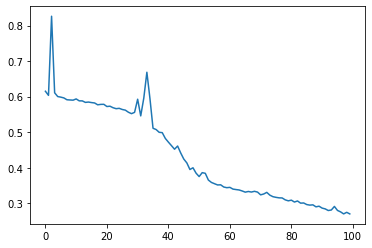

In [33]:
plt.plot(loss_list)